# *VAE_gen_2*
# Génération de mélodies avec un VAE avec amélioration du traitement des données


## Prétraitement des données 

Dans ce notebook les données musicales vont être représentées par deux séquences de nombres. Une séquence représente les notes et l'autre le rythme. Ces séquences seront ensuite normalisées pour être utilisées pour entrainer deux modèles d'autoencodeurs différents. Ainsi, nous allons créé un modèle d'autoencodeur pour le rythme et un pour les notes. 

Cette méthode nous permet de supprimer le problèmes que nous rencontrions précédemment avec les 1 pour former le rythme. De plus, étant donné que le rythme et le choix des notes sont des actions différentes nous espérons avoir de meilleurs résultats. 

Initialement, nous avions pensé faire deux séquences et les concaténer pour entrainer un seul modèle mais nous avons changé d'avis. Nous pensons que faire deux modèles pour ces deux actions est plus intéréssant. En fonction du temps que nous avons et des résultats obtenus nous allons peut être également entrainer un modèle de ce type. 

In [1]:
## Lecture des fichiers de musique

import os
import music21 as m21

def load_songs(data_path, max_songs_nb):
    songs = []
    for path, subdirs, files in os.walk(data_path):
        for file in files:
            if file[-3:] == "krn":
                #print(os.path.join(path, file))
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
                max_songs_nb -= 1
                if max_songs_nb == 0 : return songs
    return songs

DATASET_PATH = "data/han"

print("loading data...")
songs = load_songs(DATASET_PATH, 1000)
print("songs loaded")

loading data...


humdrum.spineParser: WARNING: Error in parsing event ('*MX') at position 9 for spine None: Incorrect meter: *MX found
humdrum.spineParser: WARNING: Error in parsing event ('*MX') at position 9 for spine None: Incorrect meter: *MX found
humdrum.spineParser: WARNING: Error in parsing event ('*MX') at position 9 for spine None: Incorrect meter: *MX found
humdrum.spineParser: WARNING: Error in parsing event ('*MX') at position 9 for spine None: Incorrect meter: *MX found
humdrum.spineParser: WARNING: Error in parsing event ('*MX') at position 12 for spine None: Incorrect meter: *MX found
humdrum.spineParser: WARNING: Error in parsing event ('*MX') at position 9 for spine None: Incorrect meter: *MX found
humdrum.spineParser: WARNING: Error in parsing event ('*MX') at position 9 for spine None: Incorrect meter: *MX found
humdrum.spineParser: WARNING: Error in parsing event ('*MZ') at position 12 for spine None: Incorrect meter: *MZ found
humdrum.spineParser: WARNING: Error in parsing event (

songs loaded


In [84]:
## Prétraitement des données

# Durée des notes
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]

# Vérification de la durée des notes et suppression des éléments non conformes
def has_acceptable_durations(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

# Transposition en do majeur
def transpose(song, print_enabled=False):
    # transpose song in Cmaj/Amin

    # get key signature
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]
    if print_enabled : print("old key : ", key)

    # estimate key if not indicated
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # get interval for transposition
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    
    transposed_song = song.transpose(interval)

    return transposed_song

In [ ]:
for song in songs:
    if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
        # song.show()
        # song.show("midi")
        songs.remove(song)

transposed_songs = []
for song in songs:
    transposed_songs.append(transpose(song))

In [4]:
# Information sur les notes
# Note maximale et minimal
max = 0
min = 1000
for song in transposed_songs:
    for note in song.flatten().notes:
        if note.pitch.midi > max: max = note.pitch.midi
        if note.pitch.midi < min: min = note.pitch.midi

print("max note : ", m21.pitch.Pitch(max).nameWithOctave)
print("min note : ", m21.pitch.Pitch(min).nameWithOctave)
# Affichage en nombre 
print("max note : ", max)
print("min note : ", min)


max note :  D7
min note :  D3
max note :  98
min note :  50


Les notes sont comprises entre 50 et 98, ainsi on peut forcer les silences à être soit en dessous de 50 soit au dessus de 98. 

J'ai décidé de représenté les silences par la valeurs 99. Ainsi, nous avons 50 valeurs de notes. 

On pourrait pensé que cela n'est valable que pour ce dataset mais en réalité il est assez rare de monter au dessus de D7. Bien sur cela reste à vérifier si on veut réutiliser le modèle sur un autre dataset. 

In [85]:
# Encodage des mélodies en 2 séquences (notes et durées)

def encode_song(song):
    notes = []
    durations = []
    for note in song.flatten().notesAndRests:
        if isinstance(note, m21.note.Note):
            notes.append(note.pitch.midi)
            durations.append(note.duration.quarterLength)
        elif isinstance(note, m21.note.Rest):
            notes.append(99) # 99 pour les silences
            durations.append(note.duration.quarterLength)
    return notes, durations

# Affichage du rythme et des notes au format midi 

def show_encoded_song(encoded_song):
    # Création de 2 streams
    notes_stream = m21.stream.Stream()
    durations_stream = m21.stream.Stream()

    # Notes
    notes = encoded_song[0]
    for note in notes:
        if note == 99:
            rest = m21.note.Rest()
            rest.quarterLength = 1
            notes_stream.append(rest)
        else:
            note = m21.note.Note(note)
            note.quarterLength = 1
            notes_stream.append(note)

    # Durées
    durations = encoded_song[1]
    for duration in durations:
        note = m21.note.Note(61) # DO
        note.quarterLength = duration
        durations_stream.append(note)

    # Affichage
    print("---Notes encodés---")
    notes_stream.show()
    print("---Rythmes encodés---")
    durations_stream.show()

    return notes_stream, durations_stream

encoded song notes :  [69, 69, 72, 69, 67, 64, 67, 69, 99, 74, 74, 72, 69, 67, 64, 67, 69, 99, 69, 69, 72, 67, 69, 99, 74, 74, 72, 67, 69, 99, 69, 69, 72, 69, 67, 64, 99, 74, 74, 72, 69, 67, 64, 99, 76, 76, 74, 76, 72, 79, 76, 74, 72, 69, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69]
encoded song durations :  [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 0.25, 0.25, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 1.0]
---Notes encodés---


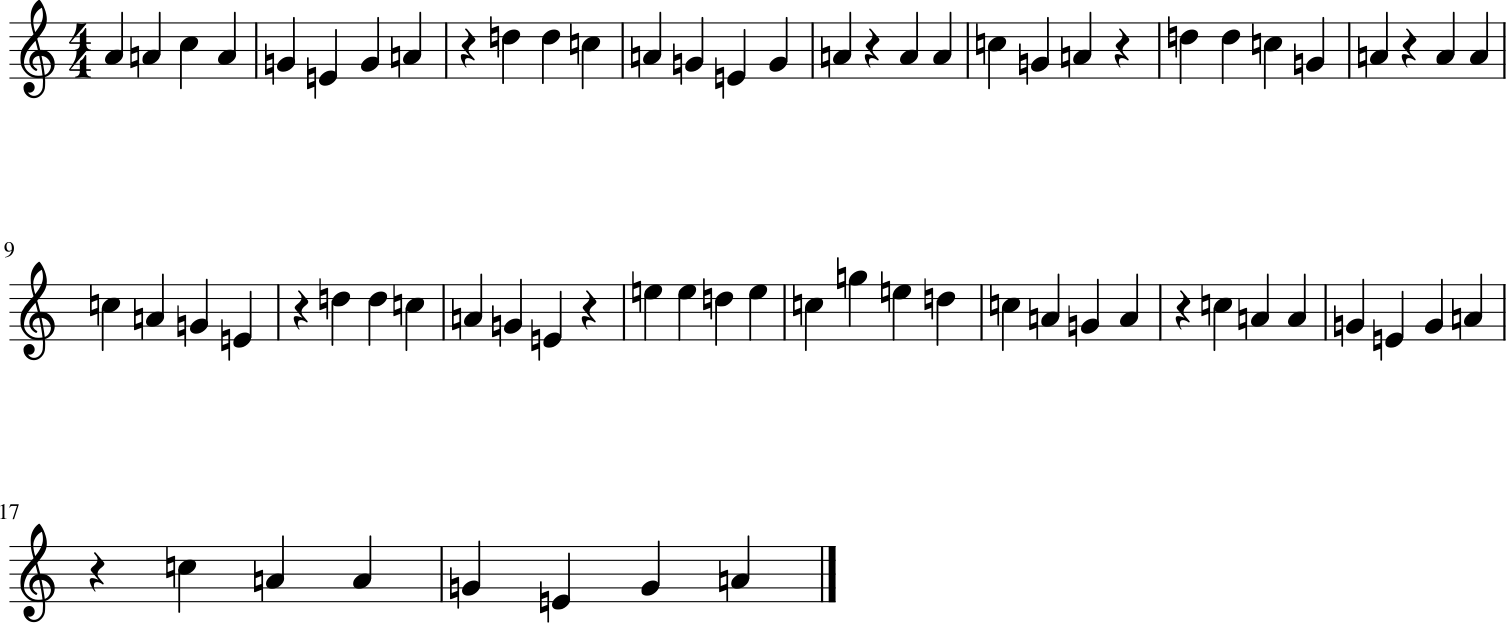

---Rythmes encodés---


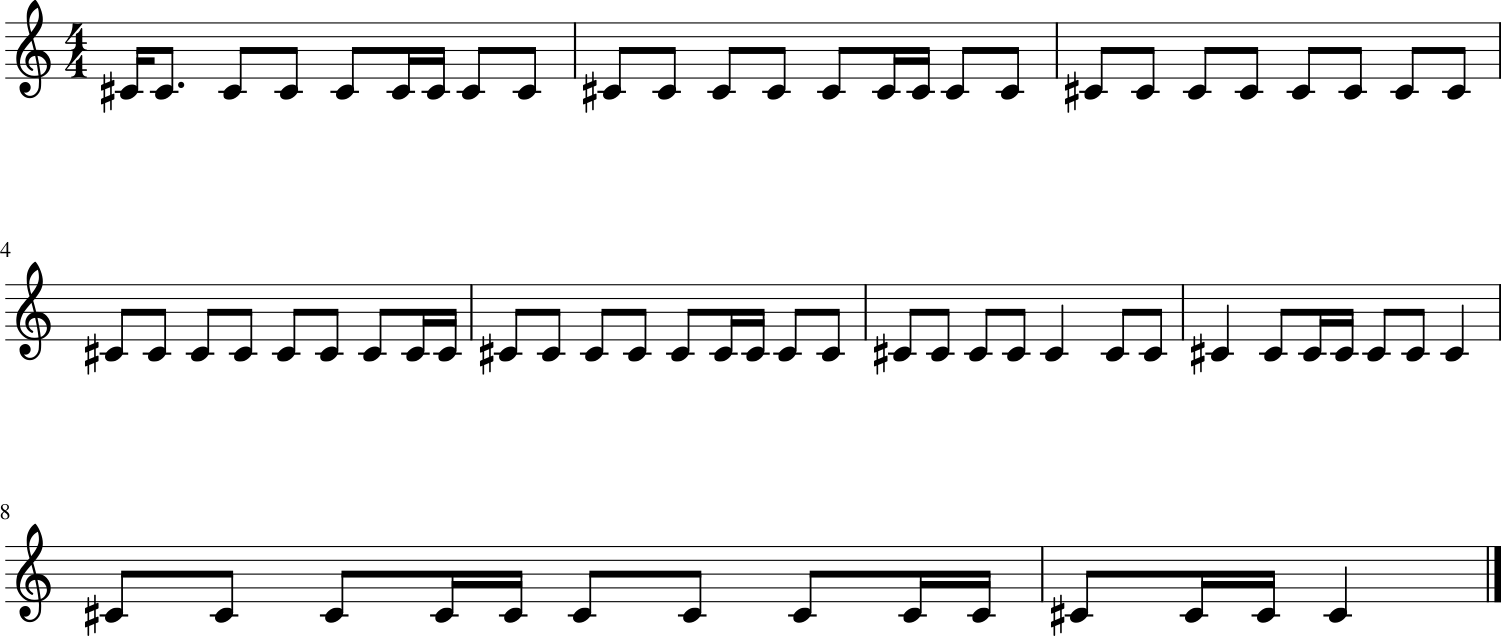

In [ ]:
# Exemple d'encodage
encoded_song = encode_song(transposed_songs[0])
print("encoded song notes : ", encoded_song[0])
print("encoded song durations : ", encoded_song[1])

encoded_song_stream = show_encoded_song(encoded_song)


In [86]:
# Fonction de décodage

def decode_song(encoded_song):
    notes = encoded_song[0]
    durations = encoded_song[1]
    decoded_song = m21.stream.Score()
    for i in range(len(notes)):
        if notes[i] == 99:
            decoded_song.append(m21.note.Rest(durations[i]))
        else:
            note = m21.note.Note()
            note.pitch.midi = notes[i]
            note.duration.quarterLength = durations[i]
            decoded_song.append(note)
    return decoded_song

Son original : 


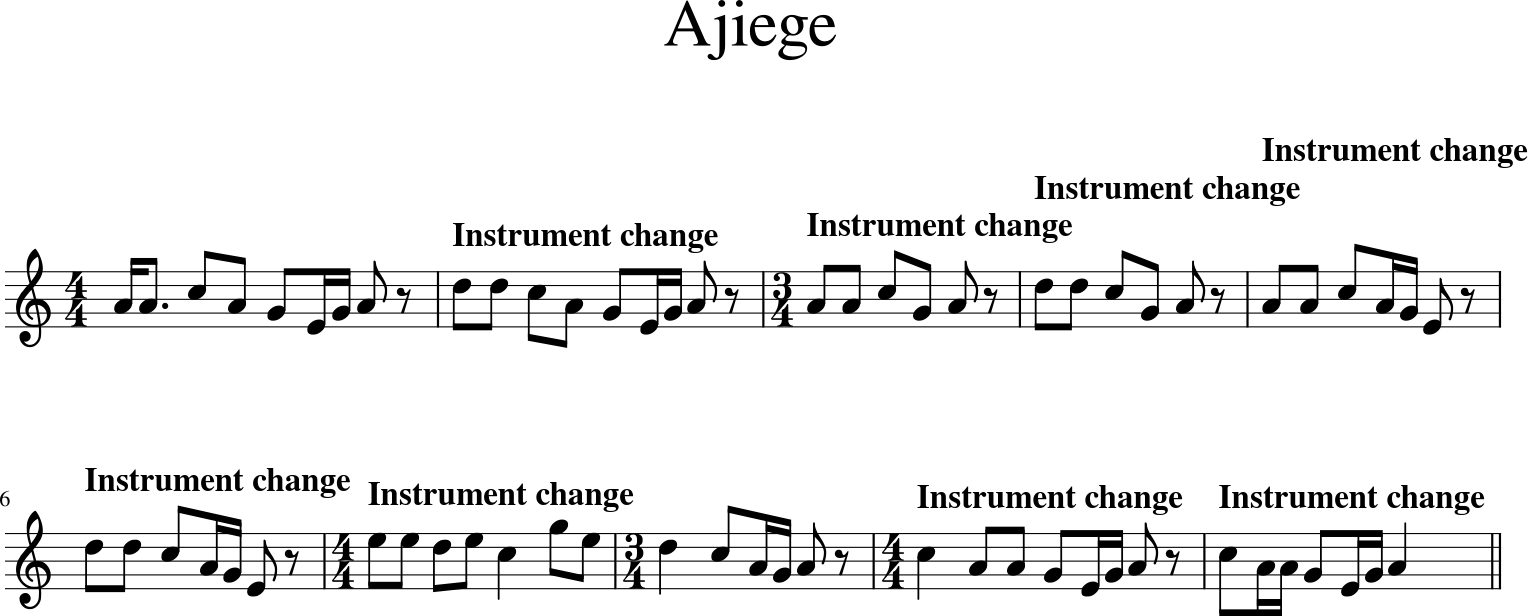

Son décodé : 


/home/am/UQAC/AP/projet/projet-env/lib/python3.12/site-packages/music21/musicxml/m21ToXml.py:427: MusicXMLWarning: <music21.stream.Score 0x7d788af46f60> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{sc} is not well-formed; see isWellFormedNotation()',


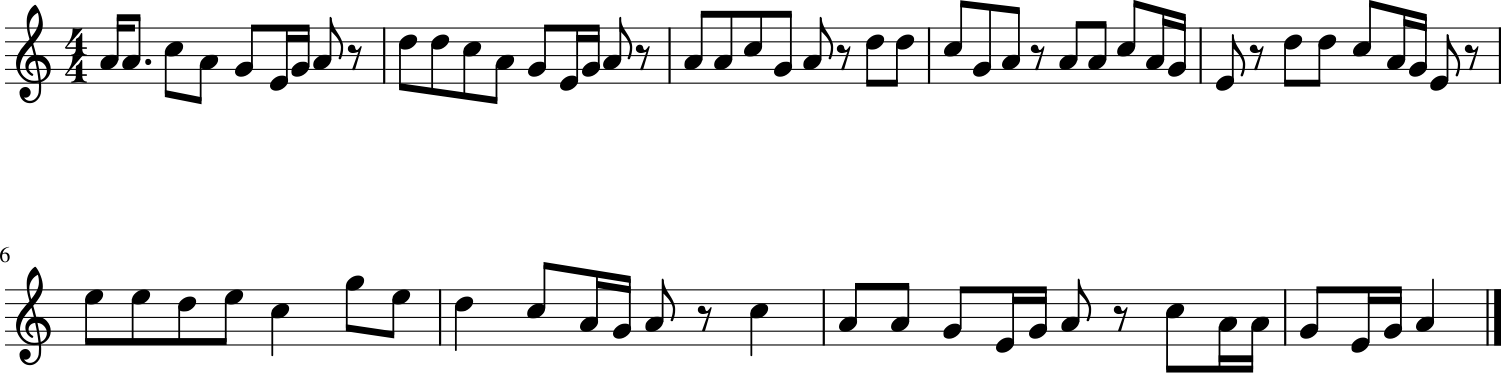

In [ ]:
# Exemple de décodage
print("Son original : ")
transposed_songs[0].show()
print("Son décodé : ")
decoded_song = decode_song(encoded_song)
decoded_song.show()


In [ ]:
# Encodage des sequences

encoded_songs = []
for song in transposed_songs:
    encoded_songs.append(encode_song(song))

# Affichage de la première séquence
print("encoded song 0 : ", encoded_songs[0][0])

encoded song 0 :  [69, 69, 72, 69, 67, 64, 67, 69, 99, 74, 74, 72, 69, 67, 64, 67, 69, 99, 69, 69, 72, 67, 69, 99, 74, 74, 72, 67, 69, 99, 69, 69, 72, 69, 67, 64, 99, 74, 74, 72, 69, 67, 64, 99, 76, 76, 74, 76, 72, 79, 76, 74, 72, 69, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69]


In [8]:
# Padding des séquences
# Il faut que toutes les séquences aient la même longueur

# Information sur les séquences 
max_sequence_length = 0
min_sequence_length = 1000
mean_sequence_length = 0
for song in encoded_songs:
    if len(song[0]) > max_sequence_length: max_sequence_length = len(song[0])
    if len(song[0]) < min_sequence_length: min_sequence_length = len(song[0])
    mean_sequence_length += len(song[0])
mean_sequence_length /= len(encoded_songs)
print("max sequence length : ", max_sequence_length)
print("min sequence length : ", min_sequence_length)
print("mean sequence length : ", mean_sequence_length)




max sequence length :  520
min sequence length :  17
mean sequence length :  73.04462242562929


In [87]:
# On va choisir une longueur de 100 pour les séquences

MAX_SEQUENCE_LENGTH = 100
# On va padder les séquences avec des silences (99) à la fin et des durées de 4
def pad_sequence(sequence, max_length):
    notes = sequence[0]
    durations = sequence[1]
    if len(notes) < max_length:
        for i in range(max_length - len(notes)):
            notes.append(99)
            durations.append(4.0)
    else :
        notes = notes[:max_length]
        durations = durations[:max_length]
    return notes, durations

In [ ]:
# Padding des séquences
# Séparation des notes et des durées
notes_padded_sequences = []
durations_padded_sequences = []
padded_encoded_songs = []
for song in encoded_songs:
    padded_sequence = pad_sequence(song, MAX_SEQUENCE_LENGTH)
    notes_padded_sequences.append(padded_sequence[0])
    durations_padded_sequences.append(padded_sequence[1])
    padded_encoded_songs.append(padded_sequence)
# Affichage de la première séquence padée
print("padded encoded song 0 : ", padded_encoded_songs[0][0])
print("padded encoded song 0 : ", padded_encoded_songs[0][1])
    
# Affichage de la longueur moyenne des séquences
mean_sequence_length = 0
for song in padded_encoded_songs:
    mean_sequence_length += len(song[0])
mean_sequence_length /= len(padded_encoded_songs)
print("mean sequence length : ", mean_sequence_length)

padded encoded song 0 :  [69, 69, 72, 69, 67, 64, 67, 69, 99, 74, 74, 72, 69, 67, 64, 67, 69, 99, 69, 69, 72, 67, 69, 99, 74, 74, 72, 67, 69, 99, 69, 69, 72, 69, 67, 64, 99, 74, 74, 72, 69, 67, 64, 99, 76, 76, 74, 76, 72, 79, 76, 74, 72, 69, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]
padded encoded song 0 :  [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 0.25, 0.25, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
mean sequence length :  100.0


### Sauvegarde des données traitées

In [3]:
# Sauvegarder les séquences pré-traitées
import numpy as np
import pickle
import gzip

def save_sequences(sequences, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(sequences, f)
    print("Sequences saved in ", filename)

def load_sequences(filename):
    with gzip.open(filename, 'rb') as f:
        sequences = pickle.load(f)
    print("Sequences loaded from ", filename)
    return sequences

In [ ]:
save_sequences(padded_encoded_songs, "encoded_songs.pkl.gz")

In [4]:
sequences = load_sequences("encoded_songs.pkl.gz")

Sequences loaded from  encoded_songs.pkl.gz


In [5]:
notes_padded_sequences = []
durations_padded_sequences = []
for song in sequences:
    notes_padded_sequences.append(song[0])
    durations_padded_sequences.append(song[1])
# Affichage de la première séquence
print("padded encoded song 0 : ", notes_padded_sequences[0])
print("padded encoded song 0 : ", durations_padded_sequences[0])

padded encoded song 0 :  [69, 69, 72, 69, 67, 64, 67, 69, 99, 74, 74, 72, 69, 67, 64, 67, 69, 99, 69, 69, 72, 67, 69, 99, 74, 74, 72, 67, 69, 99, 69, 69, 72, 69, 67, 64, 99, 74, 74, 72, 69, 67, 64, 99, 76, 76, 74, 76, 72, 79, 76, 74, 72, 69, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]
padded encoded song 0 :  [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 0.25, 0.25, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


Maintenant, on a des séquences divisées en 2 avec une partie notes et une parties rytme et elles font toutes la même taille. 

Pour la suite, je pensais normaliser les séquences mais en y réfléchissant, l'utilisation d'un one-hot semble plus approprié. J'aurais déjà pu utiliser un one-hot dans le notebook précédent mais je n'y avais pas pensé. 

Après m'être un peu plus renseigné il est difficile d'utiliser des autoencoder avec des données catégorique. Ainsi, l'utilisation de vectur one hot n'est pas forcément recommandé. J'ai donc fait un retour en arrière et je vais normaliser les données. 

## Transformation des données en tenseurs

In [92]:
# Fonction pour encoder les durées en entiers 

def encode_durations_int(duration):
    duration_int = []
    for d in duration:
        if d == 0.25:
            duration_int.append(0)
        elif d == 0.5:
            duration_int.append(1)
        elif d == 0.75:
            duration_int.append(2)
        elif d == 1.0:
            duration_int.append(3)
        elif d == 1.5:
            duration_int.append(4)
        elif d == 2.0:
            duration_int.append(5)
        elif d == 3.0:
            duration_int.append(6)
        elif d == 4.0:
            duration_int.append(7)
        else:
            print("Unknown duration : ", d)
            duration_int.append(8)
    return duration_int

# Fonction pour decoder les durées en flottants
def decode_duration_float(duration):
    float_duration = []
    for d in duration:
        if d == 0:
            float_duration.append(0.25)
        elif d == 1:
            float_duration.append(0.5)
        elif d == 2:
            float_duration.append(0.75)
        elif d == 3:
            float_duration.append(1.0)
        elif d == 4:
            float_duration.append(1.5)
        elif d == 5:
            float_duration.append(2.0)
        elif d == 6:
            float_duration.append(3.0)
        elif d == 7:
            float_duration.append(4.0)
        else:
            print("Unknown duration : ", d)
            float_duration.append(8)
    return float_duration



In [ ]:
# Pour faire des one hot il faut des entiers
# Encodage des durées en entier
durations_int = []
for duration in durations_padded_sequences:
    durations_int.append(encode_durations_int(duration))

# Affichage de la première séquence de durées
print("durations padded song 0 : ", durations_padded_sequences[0])
print("durations padded song 0 int : ", durations_int[0])

durations padded song 0 :  [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 0.25, 0.25, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
durations padded song 0 int :  [0, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 0, 0, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [7]:
# Transformation des séquences en tenseurs pytorch
import torch
import torch.nn.functional as F

notes_tensor = torch.tensor(notes_padded_sequences, dtype=torch.long)
durations_tensor = torch.tensor(durations_int, dtype=torch.long)

print("notes tensor shape : ", notes_tensor.shape)
print("durations tensor shape : ", durations_tensor.shape)

notes tensor shape :  torch.Size([874, 100])
durations tensor shape :  torch.Size([874, 100])


## Entrainement

### Modèle VAE inspiré du code de Jackson Kang 
https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [11]:
# Model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self, input_dim=1, hidden_dim=400, latent_dim=200, output_dim=100 ,sequence_length=100, device='cpu'):
        super(VAE, self).__init__()

        self.sequence_length = sequence_length
        
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)


        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def encode(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                 
        
        return mean, log_var

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)        # sampling epsilon        
        z = mean + logvar*epsilon                          # reparameterization trick
        return z

    def decode(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


### Génération de notes

In [ ]:
# Normalisation
notes_tensor_normalized = (notes_tensor - 50) / (99 - 50)

# Reshape 
notes_tensor_normalized = notes_tensor_normalized.unsqueeze(-1)  # Cela donne (874, 100, 1)
# Affichage de la forme
print("notes tensor normalized shape : ", notes_tensor_normalized.shape)

In [38]:
# Création du modèle
vae_notes = VAE(input_dim=1, hidden_dim=500, latent_dim=250, output_dim =1, sequence_length=100)  
vae_notes.to('cuda' if torch.cuda.is_available() else 'cpu')  

# Optimiseur
optimizer = optim.Adam(vae_notes.parameters(), lr=1e-5, weight_decay=1e-6)

# Fonction de perte (combinaison de BCE et KL divergence)
def loss_function(recon_x, x, mean, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')  # Perte de reconstruction
    KL = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())  # Divergence KL
    return BCE + KL


In [39]:
# Entraînement
epochs = 200
batch_size = 32  

# Assurer que les données sont sur le bon device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
notes_tensor_normalized = notes_tensor_normalized.to(device)

for epoch in range(epochs):
    vae_notes.train()
    running_loss = 0.0
    
    # Parcours des données par batchs
    for i in range(0, len(notes_tensor_normalized), batch_size):
        batch = notes_tensor_normalized[i:i+batch_size]
        optimizer.zero_grad()

        # Passage avant (forward pass)
        x_hat, mean, logvar = vae_notes(batch)

        # Calcul de la perte
        loss = loss_function(x_hat, batch, mean, logvar)
        running_loss += loss.item()

        # Rétropropagation
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / (len(notes_tensor_normalized) // batch_size)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/200], Loss: 6613.0784
Epoch [2/200], Loss: 3775.0244
Epoch [3/200], Loss: 2256.5463
Epoch [4/200], Loss: 1425.8615
Epoch [5/200], Loss: 965.7417
Epoch [6/200], Loss: 711.4408
Epoch [7/200], Loss: 571.6439
Epoch [8/200], Loss: 493.4520
Epoch [9/200], Loss: 448.2364
Epoch [10/200], Loss: 420.9088
Epoch [11/200], Loss: 403.1059
Epoch [12/200], Loss: 390.3805
Epoch [13/200], Loss: 380.2164
Epoch [14/200], Loss: 371.1748
Epoch [15/200], Loss: 362.3508
Epoch [16/200], Loss: 352.8884
Epoch [17/200], Loss: 342.3963
Epoch [18/200], Loss: 330.5965
Epoch [19/200], Loss: 317.0639
Epoch [20/200], Loss: 301.5405
Epoch [21/200], Loss: 284.3047
Epoch [22/200], Loss: 266.0749
Epoch [23/200], Loss: 247.2418
Epoch [24/200], Loss: 228.2503
Epoch [25/200], Loss: 209.7797
Epoch [26/200], Loss: 192.3545
Epoch [27/200], Loss: 176.3357
Epoch [28/200], Loss: 161.8081
Epoch [29/200], Loss: 148.7766
Epoch [30/200], Loss: 137.1259
Epoch [31/200], Loss: 126.7343
Epoch [32/200], Loss: 117.5044
Epoch [33/200

In [45]:
# Sauvegarde 
torch.save(vae_notes.state_dict(), 'vae_model.pth')

In [ ]:
# Récupérer le modèle téléchargé
vae_notes = VAE(input_dim=1, hidden_dim=500, latent_dim=250, sequence_length=100)
vae_notes.load_state_dict(torch.load('vae_model.pth'))
vae_notes.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae_notes.to(device)  # Assurer que le modèle est sur le bon device


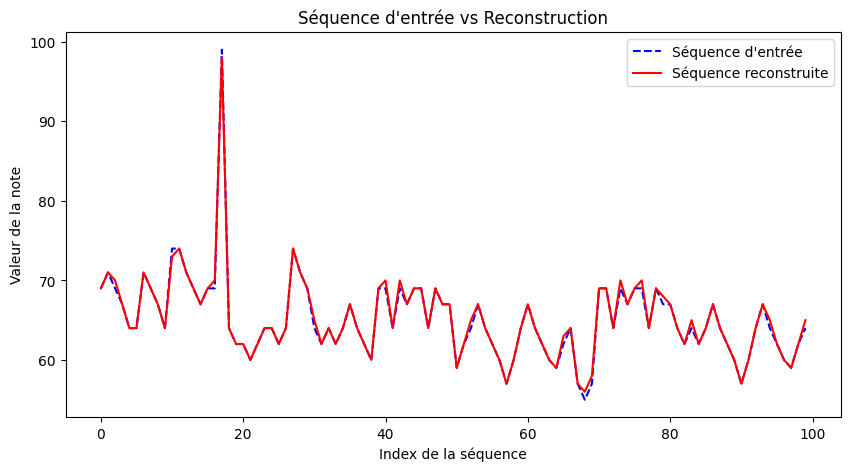

In [43]:
import matplotlib.pyplot as plt
import numpy as np

sample_idx = 10  # Choisir l'index d'un échantillon (tu peux en choisir un autre)
sample_input = notes_tensor_normalized[sample_idx:sample_idx+1].to(device)  # Séquence d'entrée normalisée

# Reconstruction
vae_notes.eval()  # Assurer que le modèle est en mode évaluation
with torch.no_grad():
    reconstructed, _, _ = vae_notes(sample_input)

# Rescale entre 50 et 99
reconstructed = reconstructed.squeeze().cpu().numpy()  
reconstructed = reconstructed * (99 - 50) + 50 
reconstructed = np.round(reconstructed).astype(int) 

# Afficher l'entrée et la reconstruction
original_sequence = sample_input.squeeze().cpu().numpy() * (99 - 50) + 50  
plt.figure(figsize=(10, 5))
plt.plot(original_sequence, label='Séquence d\'entrée', linestyle='--', color='blue')
plt.plot(reconstructed, label='Séquence reconstruite', color='red')
plt.legend()
plt.title("Séquence d'entrée vs Reconstruction")
plt.xlabel("Index de la séquence")
plt.ylabel("Valeur de la note")
plt.show()


On observe des notifications mineures. Les résultats sont très proche des mélodies originales avec tout de même quelques modifications qui permettent de créer de la génération. Encore faut-il écouter le résultat pour savoir si ses modifications sont intéressantes.

In [44]:
reconstructed

array([69, 71, 70, 67, 64, 64, 71, 69, 67, 64, 73, 74, 71, 69, 67, 69, 70,
       98, 64, 62, 62, 60, 62, 64, 64, 62, 64, 74, 71, 69, 65, 62, 64, 62,
       64, 67, 64, 62, 60, 69, 70, 64, 70, 67, 69, 69, 64, 69, 67, 67, 59,
       62, 65, 67, 64, 62, 60, 57, 60, 64, 67, 64, 62, 60, 59, 63, 64, 57,
       56, 58, 69, 69, 64, 70, 67, 69, 70, 64, 69, 68, 67, 64, 62, 65, 62,
       64, 67, 64, 62, 60, 57, 60, 64, 67, 65, 62, 60, 59, 62, 65])

### Génération de rythme

In [46]:
## Entrainement pour le rythme

# Normalisation
durations_tensor_normalized = durations_tensor / 7.0  # Normaliser entre 0 et 1
# Reshape
durations_tensor_normalized = durations_tensor_normalized.unsqueeze(-1)  # Cela donne (874, 100, 1)
# Affichage de la forme
print("durations tensor normalized shape : ", durations_tensor_normalized.shape)

durations tensor normalized shape :  torch.Size([874, 100, 1])


In [ ]:
# Création du modèle
vae_durations = VAE(input_dim=1, hidden_dim=500, latent_dim=300, output_dim=1, sequence_length=100)  
vae_durations.to('cuda' if torch.cuda.is_available() else 'cpu')  

# Optimiseur
optimizer = optim.Adam(vae_durations.parameters(), lr=1e-3)

# Fonction de perte (combinaison de BCE et KL divergence)
def loss_function(recon_x, x, mean, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')  # Perte de reconstruction
    KL = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())  # Divergence KL
    return BCE + KL

In [76]:
# Entraînement
epochs = 8
batch_size = 64

# Assurer que les données sont sur le bon device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
durations_tensor_normalized = durations_tensor_normalized.to(device)

for epoch in range(epochs):
    vae_durations.train()
    running_loss = 0.0
    
    # Parcours des données par batchs
    for i in range(0, len(durations_tensor_normalized), batch_size):
        batch = durations_tensor_normalized[i:i+batch_size]
        optimizer.zero_grad()

        # Passage avant (forward pass)
        x_hat, mean, logvar = vae_durations(batch)

        # Calcul de la perte
        loss = loss_function(x_hat, batch, mean, logvar)
        running_loss += loss.item()

        # Rétropropagation
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / (len(durations_tensor_normalized) // batch_size)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/8], Loss: 4428.5347
Epoch [2/8], Loss: 502.8366
Epoch [3/8], Loss: 832.2728
Epoch [4/8], Loss: 552.5694
Epoch [5/8], Loss: 261.7817
Epoch [6/8], Loss: 107.2330
Epoch [7/8], Loss: 59.4430
Epoch [8/8], Loss: 40.2802


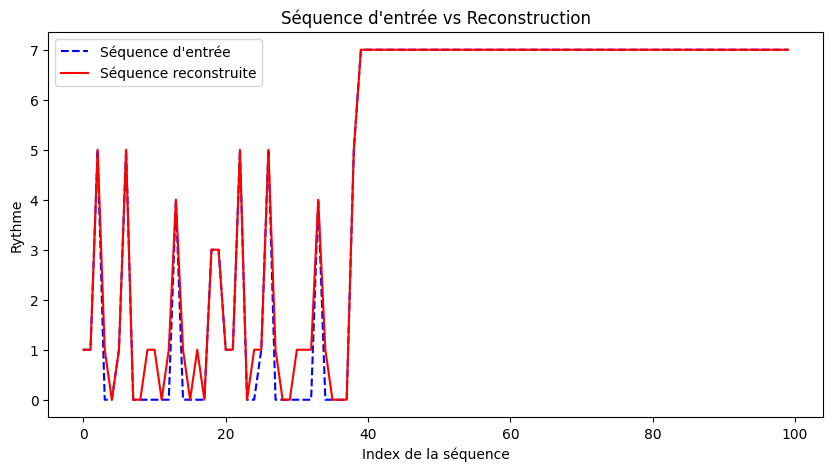

In [78]:
import matplotlib.pyplot as plt
import numpy as np

sample_idx = 5  # Choisir l'index d'un échantillon (tu peux en choisir un autre)
sample_input = durations_tensor_normalized[sample_idx:sample_idx+1].to(device)  # Séquence d'entrée normalisée

# Reconstruction
vae_durations.eval()  # Assurer que le modèle est en mode évaluation
with torch.no_grad():
    reconstructed, _, _ = vae_durations(sample_input)

reconstructed = reconstructed.squeeze().cpu().numpy()  
reconstructed = reconstructed * 7.0  # Rescale entre 0 et 7
reconstructed = np.round(reconstructed).astype(int) 

# Afficher l'entrée et la reconstruction
original_sequence = sample_input.squeeze().cpu().numpy() * 7.0  # Rescale entre 0 et 7
plt.figure(figsize=(10, 5))
plt.plot(original_sequence, label='Séquence d\'entrée', linestyle='--', color='blue')
plt.plot(reconstructed, label='Séquence reconstruite', color='red')
plt.legend()
plt.title("Séquence d'entrée vs Reconstruction")
plt.xlabel("Index de la séquence")
plt.ylabel("Rythme")
plt.show()


In [79]:
## Sauvegarde du modèle
torch.save(vae_durations.state_dict(), 'vae_model_durations.pth')

In [ ]:
## Récupérer le modèle téléchargé
vae_durations = VAE(input_dim=1, hidden_dim=500, latent_dim=300, sequence_length=100)
vae_durations.load_state_dict(torch.load('vae_model_durations.pth'))
vae_durations.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae_durations.to(device)  # Assurer que le modèle est sur le bon device

## Génération de mélodies

In [117]:
## Choix d'un morceau
import music21 as m21
melody_file = "data/han/han0001.krn"
melody = m21.converter.parse(melody_file)

In [121]:
### Pré-traitement 

# Durée des notes
if not has_acceptable_durations(melody, ACCEPTABLE_DURATIONS):
    print("Le morceau ne respecte pas les durées acceptables")
else :
    print("Le morceau respecte les durées acceptables")
    # Transposition en do majeur
    melody_transposed = transpose(melody)
    # Encodage
    melody_encoded = encode_song(melody_transposed)
    print("Longueur du morceau original : ", len(melody_encoded[0]))   
    # Padding
    melody_padded = pad_sequence(melody_encoded, MAX_SEQUENCE_LENGTH)
    # Résultats
    melody_notes = melody_padded[0]
    melody_durations = melody_padded[1]
    print("Mélodie pré-traitée")
    

Le morceau respecte les durées acceptables
Longueur du morceau original :  64
Mélodie pré-traitée


In [122]:
# Encodage des durées en entier
melody_durations_int = encode_durations_int(melody_durations)

In [123]:
### Création de tenseurs
melody_notes_tensor = torch.tensor(melody_notes, dtype=torch.float32).unsqueeze(0).to(device)
melody_durations_tensor = torch.tensor(melody_durations_int, dtype=torch.float32).unsqueeze(0).to(device)


In [124]:
### Normalisation
melody_notes_tensor_normalized = (melody_notes_tensor - 50) / (99 - 50)
melody_durations_tensor_normalized = melody_durations_tensor / 7.0

### Reshape
melody_notes_tensor_normalized = melody_notes_tensor_normalized.unsqueeze(-1)  # Cela donne (1, 100, 1)
melody_durations_tensor_normalized = melody_durations_tensor_normalized.unsqueeze(-1)  # Cela donne (1, 100, 1)

In [125]:
### Reconstruction

# Reconstruction des notes
vae_notes.eval()  # Assurer que le modèle est en mode évaluation
with torch.no_grad():
    melody_reconstructed, _, _ = vae_notes(melody_notes_tensor_normalized)
melody_reconstructed = melody_reconstructed.squeeze().cpu().numpy()
melody_reconstructed = melody_reconstructed * (99 - 50) + 50
melody_reconstructed = np.round(melody_reconstructed).astype(int)
melody_reconstructed = melody_reconstructed.tolist()

# Reconstruction des durées
vae_durations.eval()  # Assurer que le modèle est en mode évaluation
with torch.no_grad():
    melody_durations_reconstructed, _, _ = vae_durations(melody_durations_tensor_normalized)
melody_durations_reconstructed = melody_durations_reconstructed.squeeze().cpu().numpy()
melody_durations_reconstructed = melody_durations_reconstructed * 7.0
melody_durations_reconstructed = np.round(melody_durations_reconstructed).astype(int)
melody_durations_reconstructed = melody_durations_reconstructed.tolist()
melody_durations_reconstructed = decode_duration_float(melody_durations_reconstructed)


In [129]:
### Racourcir les séquences à la taille de la mélodie d'origine
melody_reconstructed = melody_reconstructed[:64]
melody_durations_reconstructed = melody_durations_reconstructed[:64]

In [130]:
### Reconstruction du morceau
encoded_melody = (melody_reconstructed, melody_durations_reconstructed)
decoded_melody = decode_song(encoded_melody)

In [131]:
### Ecoute 

# Morceau original
print("Morceau original : ")
melody.show("midi")

# Morceau reconstruit
print("Morceau reconstruit : ")
decoded_melody.show("midi")

Morceau original : 


Morceau reconstruit : 


# Génération

In [133]:
## Fonctions de pré-traitement

import os
import music21 as m21

# Longueur maximale des séquences
MAX_SEQUENCE_LENGTH = 100

# Durée des notes
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]

# Vérification de la durée des notes et suppression des éléments non conformes
def has_acceptable_durations(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

# Transposition en do majeur
def transpose(song, print_enabled=False):
    # transpose song in Cmaj/Amin

    # get key signature
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]
    if print_enabled : print("old key : ", key)

    # estimate key if not indicated
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # get interval for transposition
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    
    transposed_song = song.transpose(interval)

    return transposed_song

# Encodage des mélodies en 2 séquences (notes et durées)
def encode_song(song):
    notes = []
    durations = []
    for note in song.flatten().notesAndRests:
        if isinstance(note, m21.note.Note):
            notes.append(note.pitch.midi)
            durations.append(note.duration.quarterLength)
        elif isinstance(note, m21.note.Rest):
            notes.append(99) # 99 pour les silences
            durations.append(note.duration.quarterLength)
    return notes, durations

# Fonction de décodage
def decode_song(encoded_song):
    notes = encoded_song[0]
    durations = encoded_song[1]
    decoded_song = m21.stream.Score()
    for i in range(len(notes)):
        if notes[i] == 99:
            decoded_song.append(m21.note.Rest(durations[i]))
        else:
            note = m21.note.Note()
            note.pitch.midi = notes[i]
            note.duration.quarterLength = durations[i]
            decoded_song.append(note)
    return decoded_song

# Padding
def pad_sequence(sequence, max_length):
    notes = sequence[0]
    durations = sequence[1]
    if len(notes) < max_length:
        for i in range(max_length - len(notes)):
            notes.append(99)
            durations.append(4.0)
    else :
        notes = notes[:max_length]
        durations = durations[:max_length]
    return notes, durations


# Fonction pour encoder les durées en entiers 
def encode_durations_int(duration):
    duration_int = []
    for d in duration:
        if d == 0.25:
            duration_int.append(0)
        elif d == 0.5:
            duration_int.append(1)
        elif d == 0.75:
            duration_int.append(2)
        elif d == 1.0:
            duration_int.append(3)
        elif d == 1.5:
            duration_int.append(4)
        elif d == 2.0:
            duration_int.append(5)
        elif d == 3.0:
            duration_int.append(6)
        elif d == 4.0:
            duration_int.append(7)
        else:
            print("Unknown duration : ", d)
            duration_int.append(8)
    return duration_int

# Fonction pour decoder les durées en flottants
def decode_duration_float(duration):
    float_duration = []
    for d in duration:
        if d == 0:
            float_duration.append(0.25)
        elif d == 1:
            float_duration.append(0.5)
        elif d == 2:
            float_duration.append(0.75)
        elif d == 3:
            float_duration.append(1.0)
        elif d == 4:
            float_duration.append(1.5)
        elif d == 5:
            float_duration.append(2.0)
        elif d == 6:
            float_duration.append(3.0)
        elif d == 7:
            float_duration.append(4.0)
        else:
            print("Unknown duration : ", d)
            float_duration.append(8)
    return float_duration

# Affichage du rythme et des notes au format midi 
def show_encoded_song(encoded_song):
    # Création de 2 streams
    notes_stream = m21.stream.Stream()
    durations_stream = m21.stream.Stream()

    # Notes
    notes = encoded_song[0]
    for note in notes:
        if note == 99:
            rest = m21.note.Rest()
            rest.quarterLength = 1
            notes_stream.append(rest)
        else:
            note = m21.note.Note(note)
            note.quarterLength = 1
            notes_stream.append(note)

    # Durées
    durations = encoded_song[1]
    for duration in durations:
        note = m21.note.Note(61) # DO
        note.quarterLength = duration
        durations_stream.append(note)

    # Affichage
    print("---Notes encodés---")
    notes_stream.show()
    print("---Rythmes encodés---")
    durations_stream.show()

    return notes_stream, durations_stream

In [134]:
# Model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self, input_dim=1, hidden_dim=400, latent_dim=200, output_dim=100 ,sequence_length=100, device='cpu'):
        super(VAE, self).__init__()

        self.sequence_length = sequence_length
        
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)


        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def encode(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                 
        
        return mean, log_var

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)        # sampling epsilon        
        z = mean + logvar*epsilon                          # reparameterization trick
        return z

    def decode(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [136]:
# Récupération des modèles entrainés

vae_notes = VAE(input_dim=1, hidden_dim=500, latent_dim=250, output_dim=1, sequence_length=100)
vae_notes.load_state_dict(torch.load('vae_model.pth'))
vae_notes.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae_notes.to(device)  # Assurer que le modèle est sur le bon device

vae_durations = VAE(input_dim=1, hidden_dim=500, latent_dim=300, output_dim=1, sequence_length=100)
vae_durations.load_state_dict(torch.load('vae_model_durations.pth'))
vae_durations.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [154]:
# Fonction de génération 

def gen_vae(music_file):
    file_name = os.path.basename(music_file)
    file_name = "vae_gen/"+file_name

    melody = m21.converter.parse(music_file)
    print("---Morceau original---")
    melody.show()
    melody.show("midi")

    # Pré-traitement
    if not has_acceptable_durations(melody, ACCEPTABLE_DURATIONS):
        print("Le morceau ne respecte pas les durées acceptables")
        return 
    
    print("Le morceau respecte les durées acceptables")
    # Transposition en do majeur
    melody_transposed = transpose(melody)
    print("--- Morceau transposé ---")
    melody_transposed.show()
    melody_transposed.show("midi")
    melody_transposed.write("midi", file_name.replace(".krn", "_transposed.mid"))

    # Encodage
    melody_encoded = encode_song(melody_transposed)
    print("--- Encodage ---")
    melody_encoded_notes, melody_encoded_duration = show_encoded_song(melody_encoded)
    melody_encoded_notes.show("midi")
    melody_encoded_notes.write("midi", file_name.replace(".krn", "_encoded_notes.mid"))
    melody_encoded_duration.show("midi")
    melody_encoded_duration.write("midi", file_name.replace(".krn", "_encoded_durations.mid"))
    original_len = len(melody_encoded[0])
    # Padding
    melody_padded = pad_sequence(melody_encoded, MAX_SEQUENCE_LENGTH)
    # Résultats
    melody_notes = melody_padded[0]
    melody_durations = melody_padded[1]
    print("Mélodie pré-traitée")

    # Encodage des durées en entier
    melody_durations_int = encode_durations_int(melody_durations)

    # Création de tenseurs
    melody_notes_tensor = torch.tensor(melody_notes, dtype=torch.float32).unsqueeze(0).to(device)
    melody_durations_tensor = torch.tensor(melody_durations_int, dtype=torch.float32).unsqueeze(0).to(device)
    # Normalisation
    melody_notes_tensor_normalized = (melody_notes_tensor - 50) / (99 - 50)
    melody_durations_tensor_normalized = melody_durations_tensor / 7.0
    # Reshape
    melody_notes_tensor_normalized = melody_notes_tensor_normalized.unsqueeze(-1)  # Cela donne (1, 100, 1)
    melody_durations_tensor_normalized = melody_durations_tensor_normalized.unsqueeze(-1)  # Cela donne (1, 100, 1)

    # Reconstruction
    # Reconstruction des notes
    vae_notes.eval()  # Assurer que le modèle est en mode évaluation
    with torch.no_grad():
        melody_reconstructed, _, _ = vae_notes(melody_notes_tensor_normalized)
    melody_reconstructed = melody_reconstructed.squeeze().cpu().numpy()
    melody_reconstructed = melody_reconstructed * (99 - 50) + 50
    melody_reconstructed = np.round(melody_reconstructed).astype(int)
    melody_reconstructed = melody_reconstructed.tolist()

    # Reconstruction des durées
    vae_durations.eval()  # Assurer que le modèle est en mode évaluation
    with torch.no_grad():
        melody_durations_reconstructed, _, _ = vae_durations(melody_durations_tensor_normalized)
    melody_durations_reconstructed = melody_durations_reconstructed.squeeze().cpu().numpy()
    melody_durations_reconstructed = melody_durations_reconstructed * 7.0
    melody_durations_reconstructed = np.round(melody_durations_reconstructed).astype(int)
    melody_durations_reconstructed = melody_durations_reconstructed.tolist()
    melody_durations_reconstructed = decode_duration_float(melody_durations_reconstructed)

    # Racourcir les séquences à la taille de la mélodie d'origine
    melody_reconstructed = melody_reconstructed[:original_len]
    melody_durations_reconstructed = melody_durations_reconstructed[:original_len]

    # Affichage des courbes originales et reconstruites
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(melody_notes[:original_len], label='Séquence d\'entrée', linestyle='--', color='blue')
    plt.plot(melody_reconstructed, label='Séquence reconstruite', color='red')
    plt.legend()
    plt.title("Séquence d'entrée vs Reconstruction")
    plt.xlabel("Index de la séquence")
    plt.ylabel("Valeur de la note")
    plt.subplot(2, 1, 2)
    plt.plot(melody_durations[:original_len], label='Séquence d\'entrée', linestyle='--', color='blue')
    plt.plot(melody_durations_reconstructed, label='Séquence reconstruite', color='red')
    plt.legend()
    plt.title("Séquence d'entrée vs Reconstruction")
    plt.xlabel("Index de la séquence")
    plt.ylabel("Rythme")
    plt.tight_layout()
    plt.show()


    # Reconstruction du morceau par notes et durées
    reconstructed_melody = (melody_reconstructed, melody_durations_reconstructed)
    print("--- Morceau reconstruit par notes et durées ---")
    reconstructed_melody_notes, reconstructed_melody_durations = show_encoded_song(reconstructed_melody)
    reconstructed_melody_notes.show("midi")
    reconstructed_melody_notes.write("midi", file_name.replace(".krn", "_reconstructed_notes.mid"))
    reconstructed_melody_durations.show("midi")
    reconstructed_melody_durations.write("midi", file_name.replace(".krn", "_reconstructed_durations.mid"))

    # Reconstruction du morceau
    decoded_melody = decode_song(reconstructed_melody)
    print("--- Morceau reconstruit ---")
    decoded_melody.show()
    decoded_melody.show("midi")
    decoded_melody.write("midi", file_name.replace(".krn", "_reconstructed.mid"))

    return decoded_melody
    

---Morceau original---


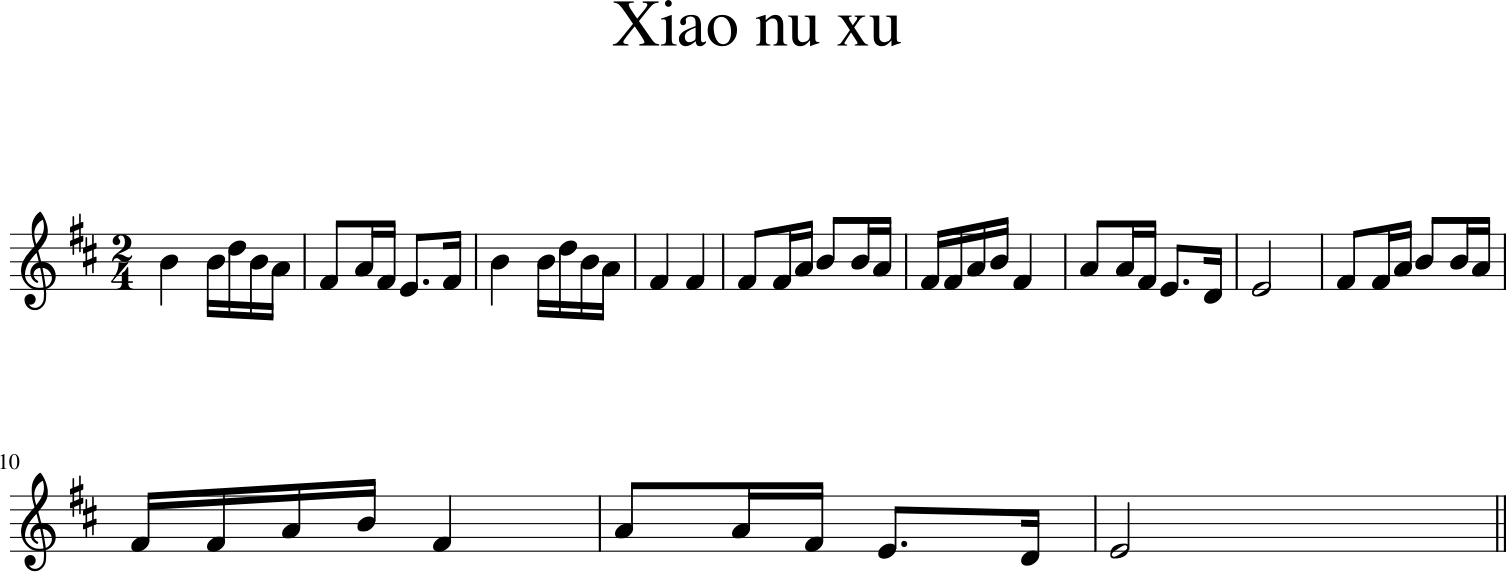

Le morceau respecte les durées acceptables
--- Morceau transposé ---


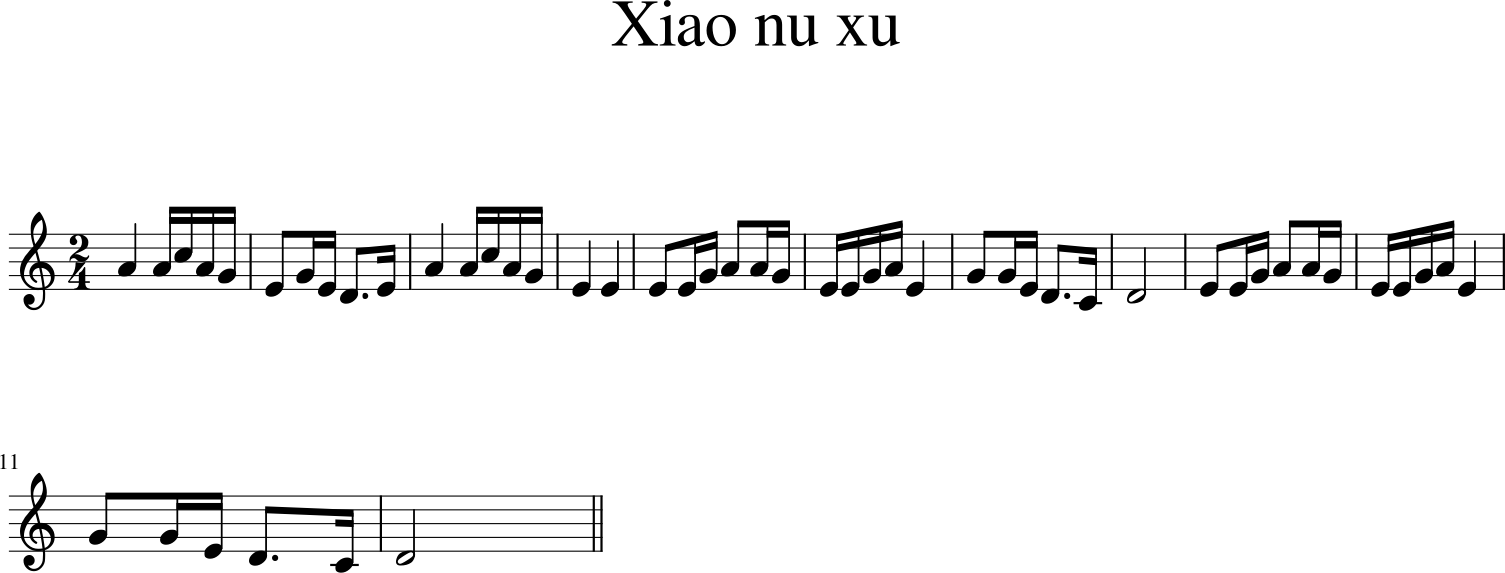

--- Encodage ---
---Notes encodés---


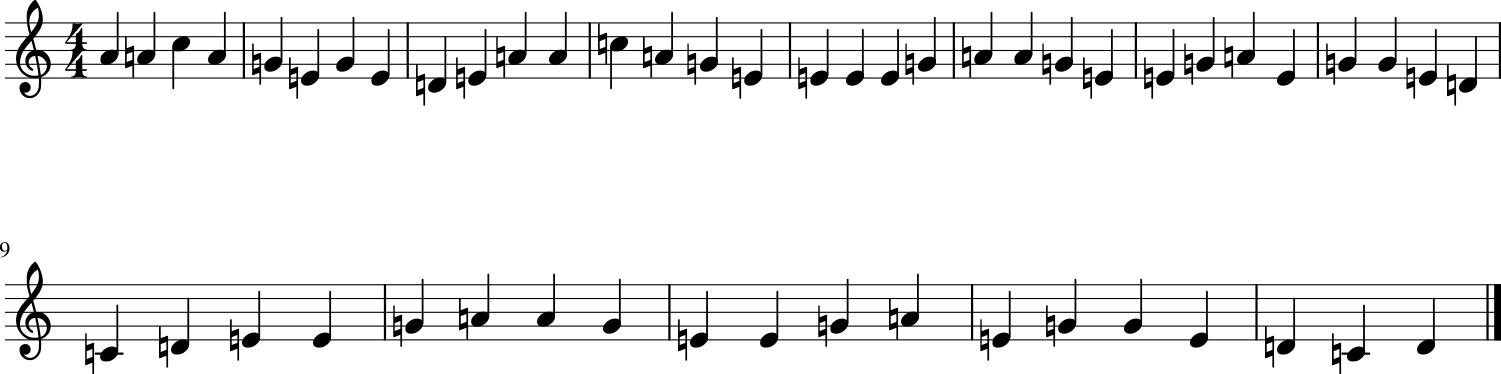

---Rythmes encodés---


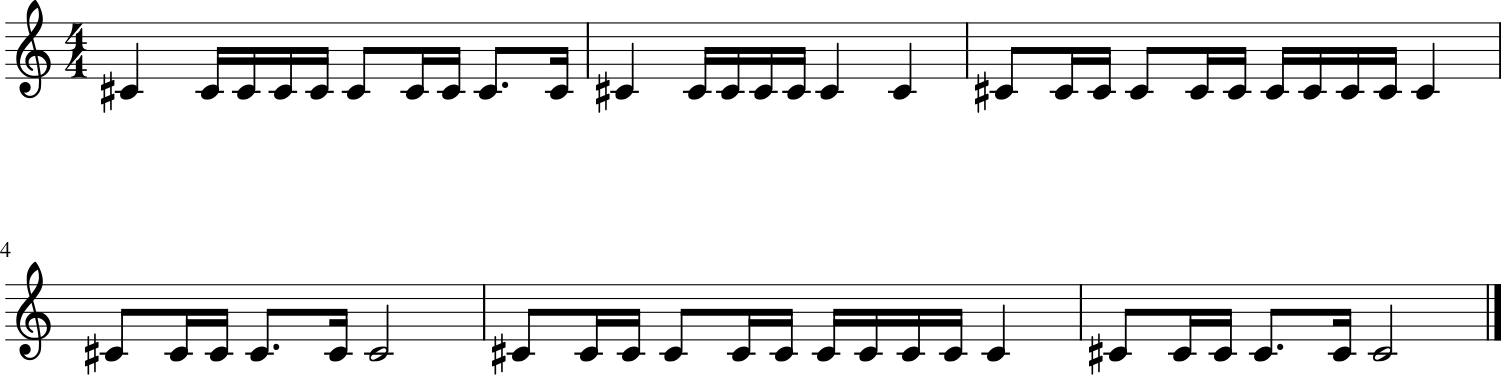

Mélodie pré-traitée


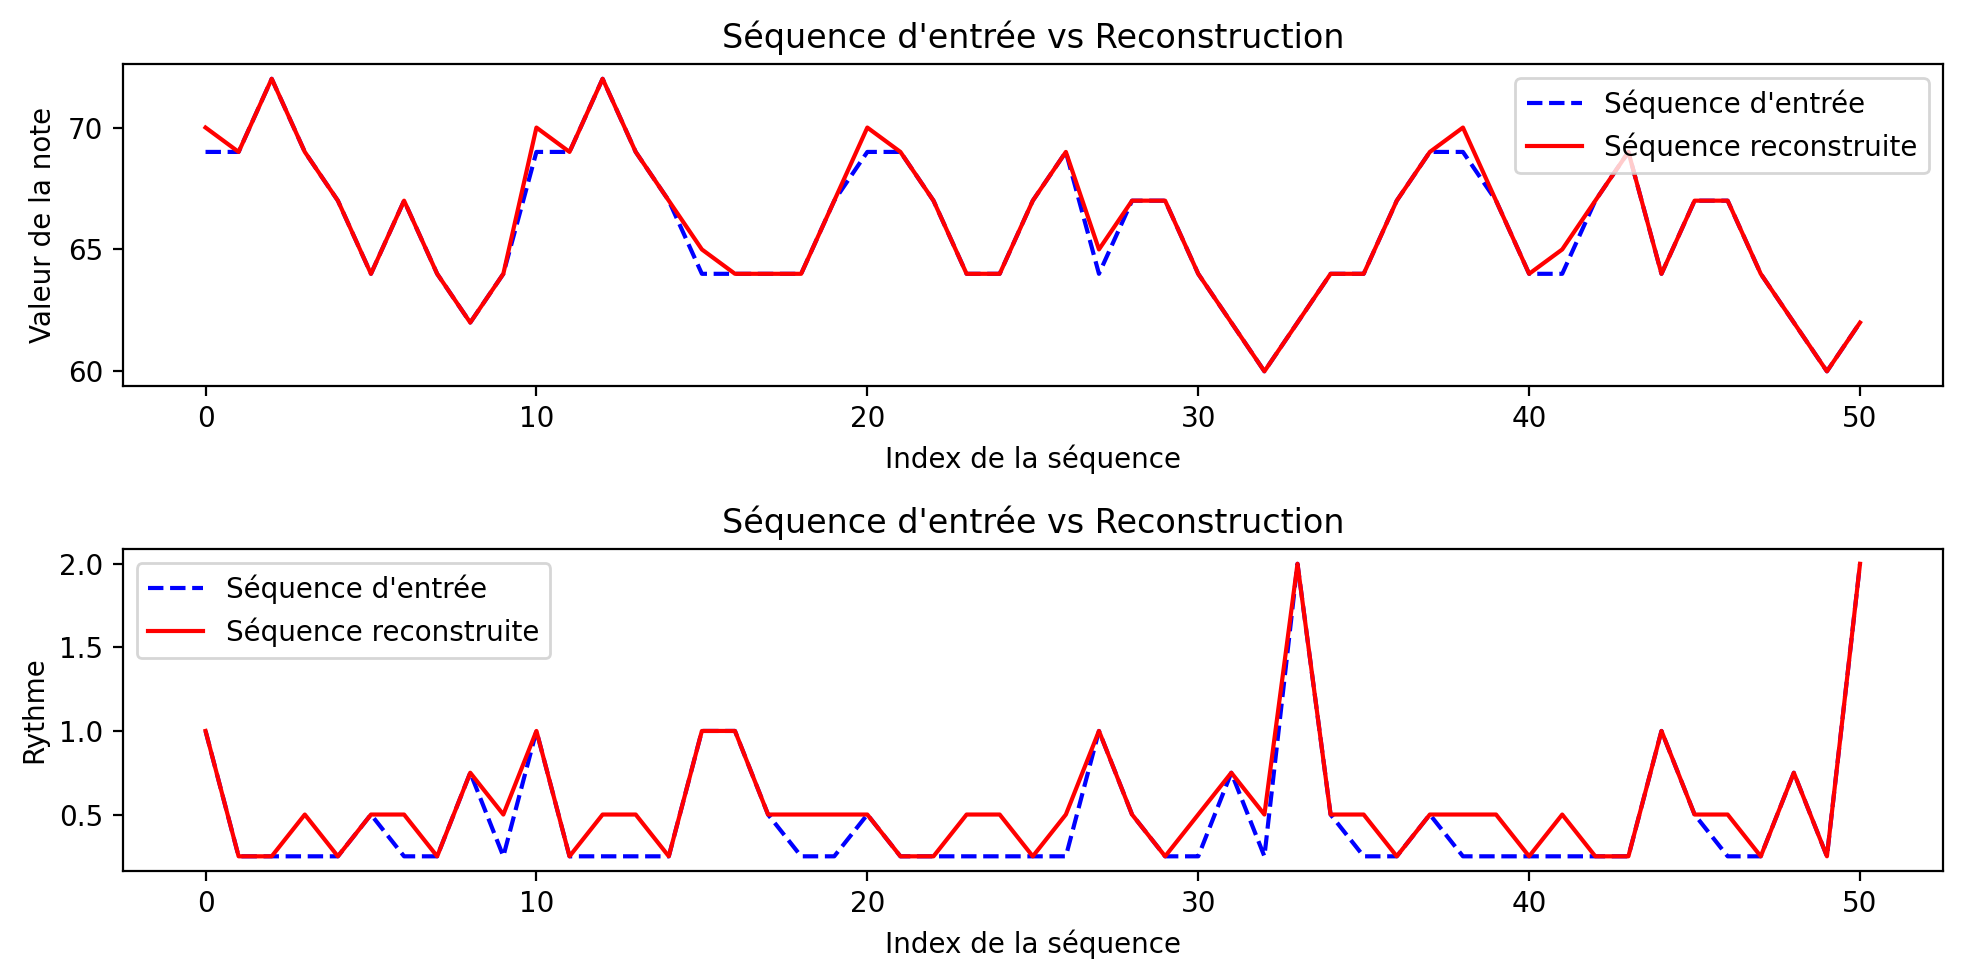

--- Morceau reconstruit par notes et durées ---
---Notes encodés---


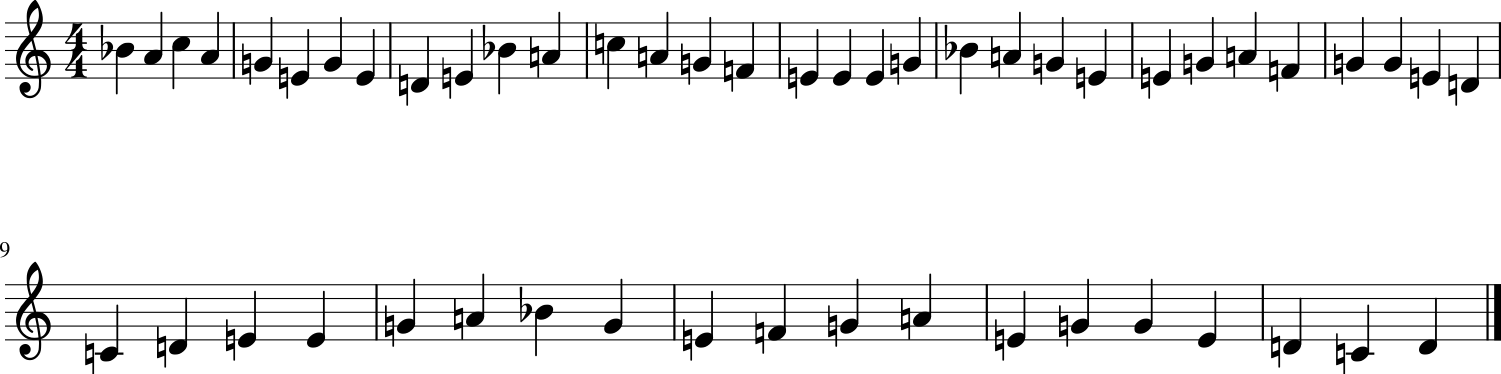

---Rythmes encodés---


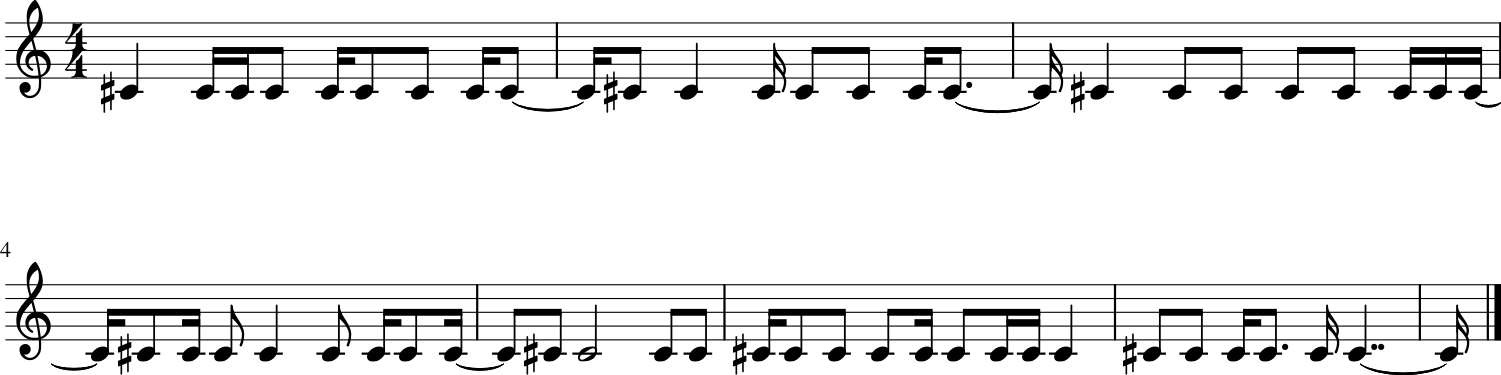

--- Morceau reconstruit ---


/home/am/UQAC/AP/projet/projet-env/lib/python3.12/site-packages/music21/musicxml/m21ToXml.py:427: MusicXMLWarning: <music21.stream.Score 0x7c451aa800b0> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{sc} is not well-formed; see isWellFormedNotation()',


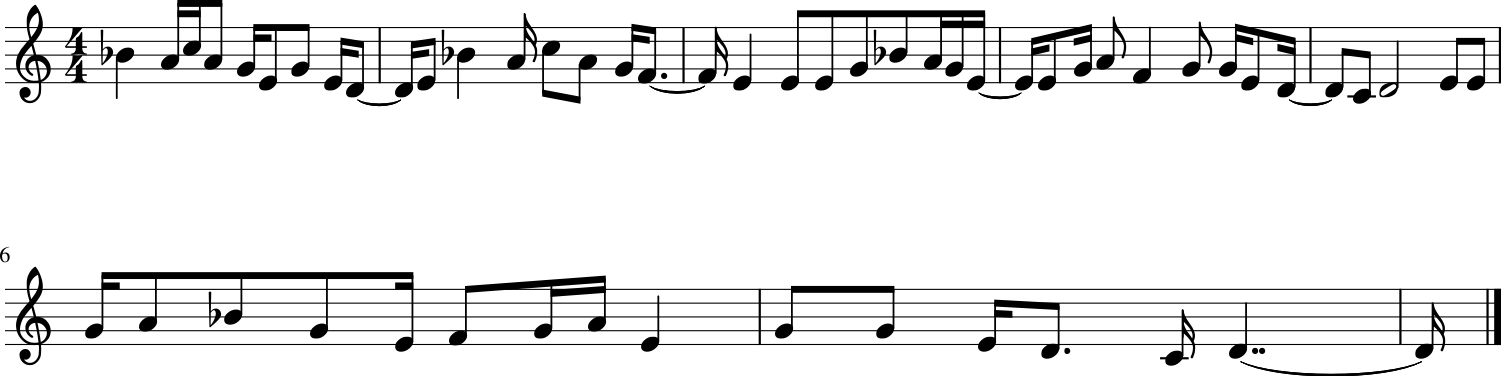

In [155]:
file = "data/han/han0030.krn"
decoded_melody = gen_vae(file)